In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../Telco-Customer-Churn-Cleaned.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges', 'tenure'])

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

target = 'tenure'

num_cols = df.select_dtypes(include=[np.number]).columns.drop(target)
cat_cols = df.select_dtypes(exclude=[np.number]).columns

--- Analiza Numeričnih spremenljivk ---


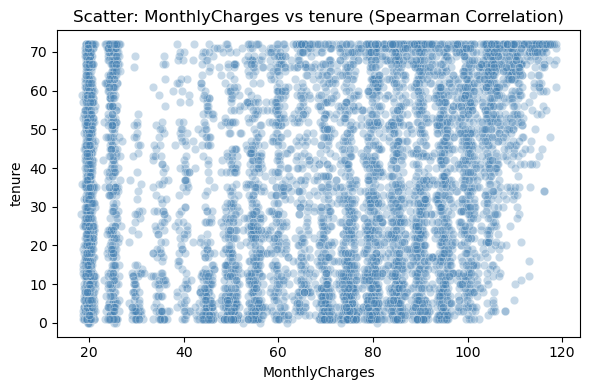

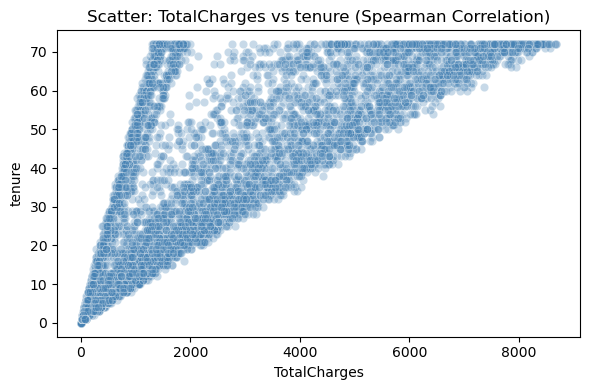

--- Analiza Nominalnih spremenljivk ---


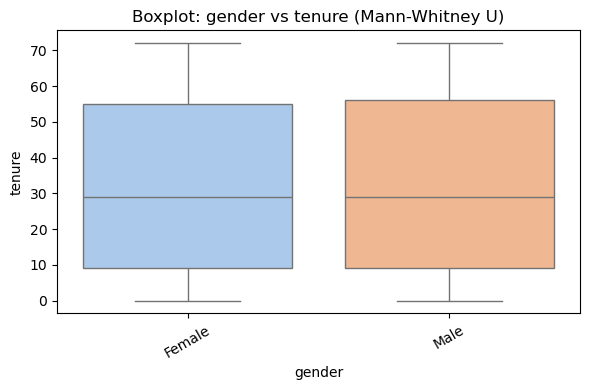

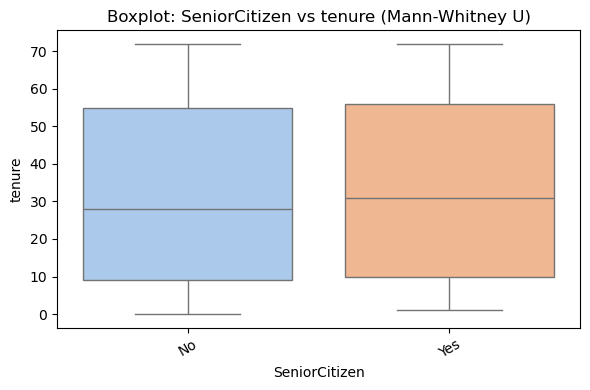

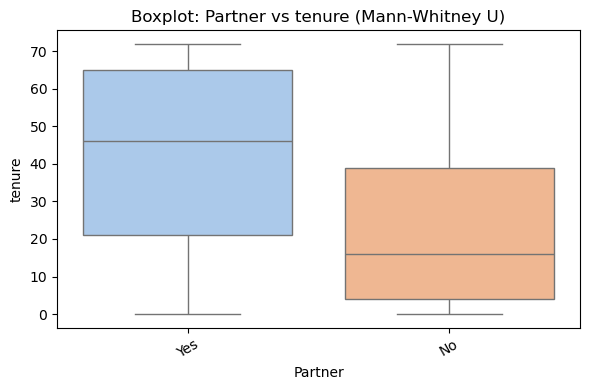

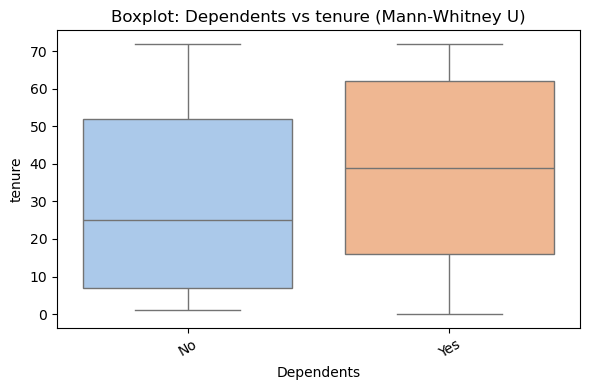

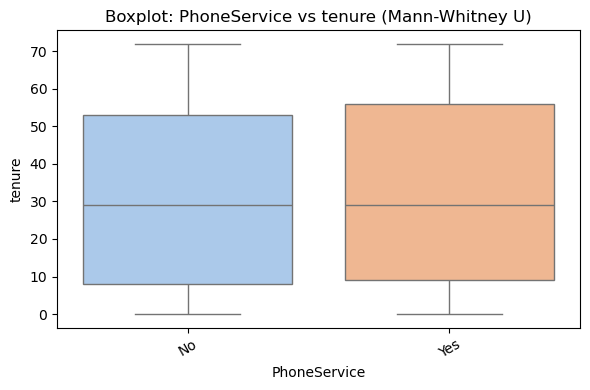

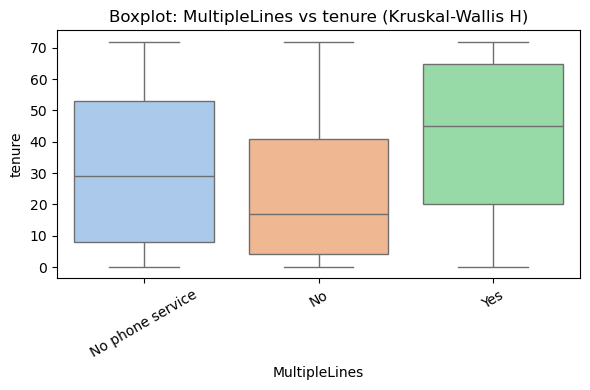

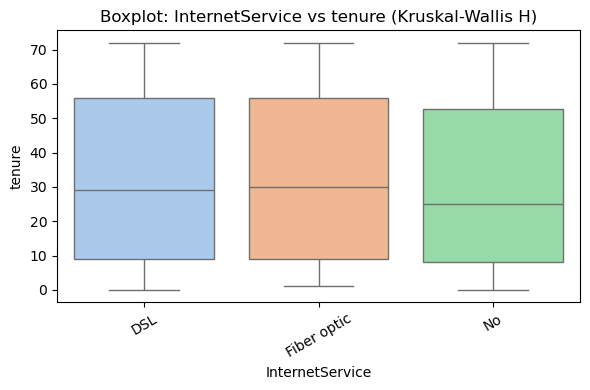

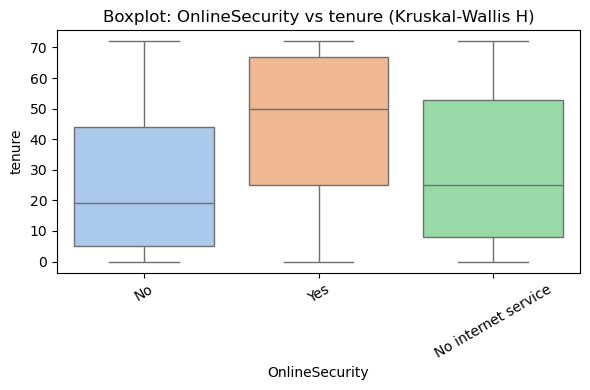

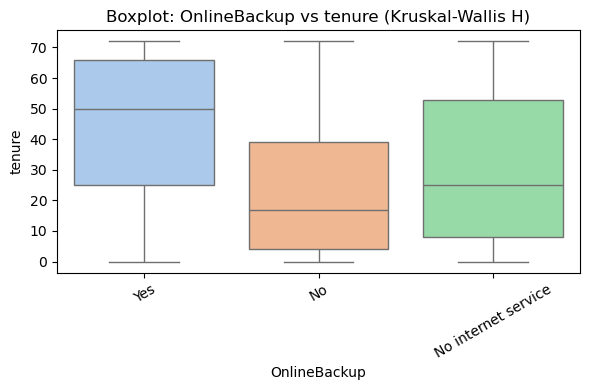

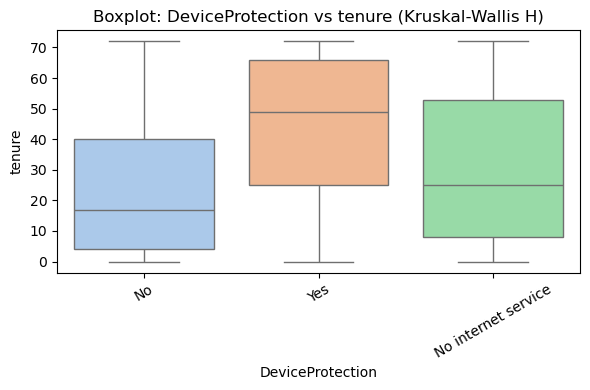

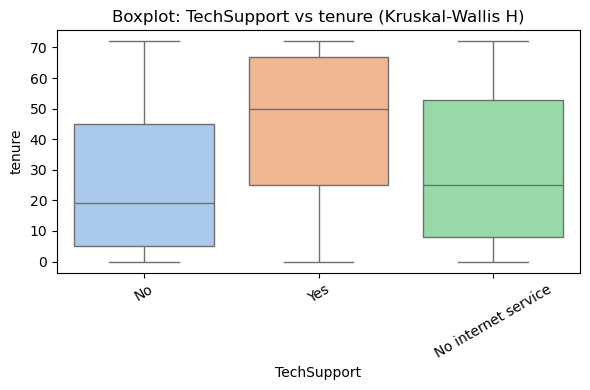

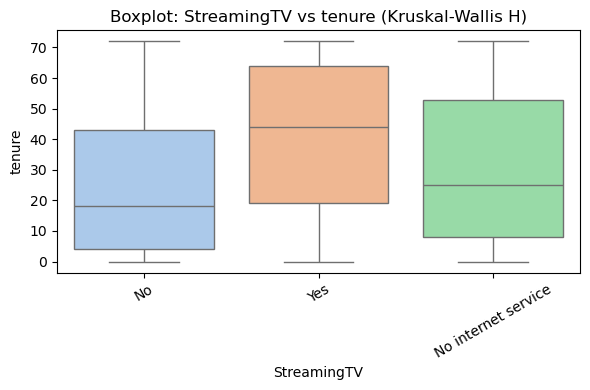

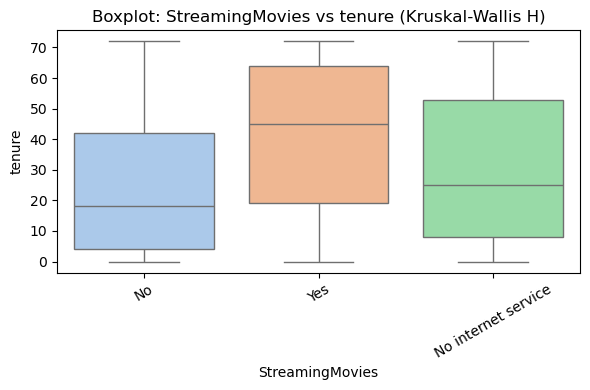

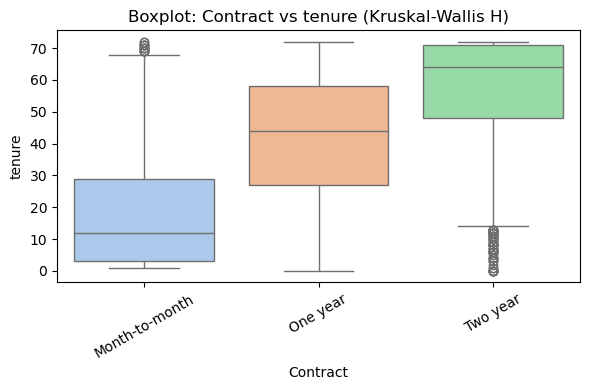

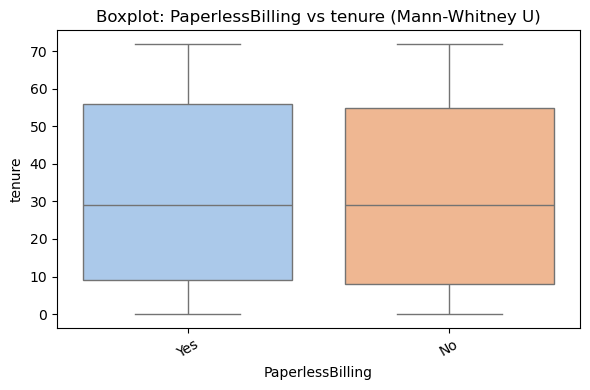

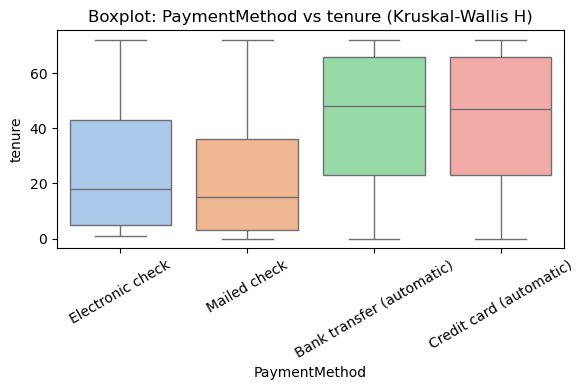

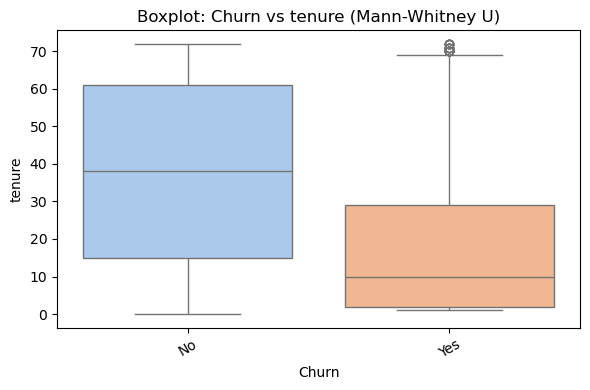

,Spremenljivka,Tip testa,Statistika,P-vrednost,Signifikantno
0,MonthlyCharges,Spearman Correlation,0.276,< 0.001,DA
1,TotalCharges,Spearman Correlation,0.890,< 0.001,DA
2,gender,Mann-Whitney U,6174973.000,0.77,NE
3,SeniorCitizen,Mann-Whitney U,3271585.000,0.119,NE
4,Partner,Mann-Whitney U,8946361.000,< 0.001,DA
5,Dependents,Mann-Whitney U,4127966.000,< 0.001,DA
6,PhoneService,Mann-Whitney U,2133195.500,0.477,NE
7,MultipleLines,Kruskal-Wallis H,858.261,< 0.001,DA
8,InternetService,Kruskal-Wallis H,11.725,0.003,DA
9,OnlineSecurity,Kruskal-Wallis H,799.359,< 0.001,DA


In [5]:
# --- Funkcija za preverjanje normalnosti (Shapiro-Wilk) ---
def is_normal(data):
    if len(data) < 3: return False 
    k2, p = stats.normaltest(data)
    return p > 0.05 

results = []

# ==========================================
# 1. VEJA: 2 NUMERIČNI (X vs Tenure)
# ==========================================
print("--- Analiza Numeričnih spremenljivk ---")
for col in num_cols:
    normal_x = is_normal(df[col])
    normal_y = is_normal(df[target])
    
    if normal_x and normal_y:
        test_name = "Pearson Correlation"
        stat, p = stats.pearsonr(df[col], df[target])
    else:
        test_name = "Spearman Correlation"
        stat, p = stats.spearmanr(df[col], df[target])
    
    results.append({
        "Spremenljivka": col,
        "Tip testa": test_name,
        "Statistika": round(stat, 3),
        "P-vrednost": round(p, 3) if p >= 0.001 else "< 0.001",
        "Signifikantno": "DA" if p < 0.05 else "NE"
    })
    
    # Grafični prikaz (Scatterplot)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df[target], alpha=0.3, color='steelblue')
    plt.title(f"Scatter: {col} vs {target} ({test_name})")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. VEJA: 1 NOMINALNA + 1 NUMERIČNA (X vs Tenure)
# ==========================================
print("--- Analiza Nominalnih spremenljivk ---")
for col in cat_cols:
    groups = df[col].unique()
    group_data = [df[df[col] == g][target] for g in groups]
    
    # Preverimo normalnost znotraj VSEH skupin
    all_normal = all(is_normal(g_data) for g_data in group_data)
    
    # A) 2 KATEGORIJI
    if len(groups) == 2:
        if all_normal:
            # Preverimo enakost varianc (Levene)
            stat_var, p_var = stats.levene(*group_data)
            if p_var > 0.05:
                test_name = "Student t-test"
                stat, p = stats.ttest_ind(*group_data, equal_var=True)
            else:
                test_name = "Welch t-test"
                stat, p = stats.ttest_ind(*group_data, equal_var=False)
        else:
            # Ni normalna porazdelitev -> Mann-Whitney U
            test_name = "Mann-Whitney U"
            stat, p = stats.mannwhitneyu(*group_data)

    # B) VEČ KOT 2 KATEGORIJI (> 2)
    else:
        if all_normal:
            # Preverimo enakost varianc (Levene)
            stat_var, p_var = stats.levene(*group_data)
            if p_var > 0.05:
                test_name = "ANOVA"
                stat, p = stats.f_oneway(*group_data)
            else:
                test_name = "Welch ANOVA"
                stat, p = stats.f_oneway(*group_data)
        else:
            # Ni normalna porazdelitev -> Kruskal-Wallis
            test_name = "Kruskal-Wallis H"
            stat, p = stats.kruskal(*group_data)

    results.append({
        "Spremenljivka": col,
        "Tip testa": test_name,
        "Statistika": round(stat, 3),
        "P-vrednost": round(p, 3) if p >= 0.001 else "< 0.001",
        "Signifikantno": "DA" if p < 0.05 else "NE"
    })

    # Grafični prikaz (Boxplot)
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], y=df[target], palette="pastel", hue=df[col], legend=False)
    plt.title(f"Boxplot: {col} vs {target} ({test_name})")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
    
results_df = pd.DataFrame(results)
display(results_df)

Interpretacija rezultatov bivariatne analize (Odvisna spremenljivka: **tenure**)
---

Analiza je preučevala povezavo med posameznimi napovednimi spremenljivkami in časom, ki ga stranka preživi pri podjetju (tenure). Ker tenure ni normalno porazdeljen, so bili uporabljeni neparametrični testi (**Spearmanova korelacija, Mann-Whitney U, Kruskal-Wallis H**).

### 1. Numerične spremenljivke (Spearmanova korelacija)
- **TotalCharges (Spearman \(p = 0.890\))**: Izjemno močna pozitivna korelacija. Ker je skupni znesek funkcija časa in mesečne naročnine (\(Total = Monthly * Tenure\)), bo zaradi visoke multikolinearnosti to spremenljivko v nekaterih modelih (npr. linearna regresija) morda treba izključiti.
- **MonthlyCharges (Spearman \(p = 0.276\))**: Šibka do zmerna pozitivna povezava. Stranke z višjimi mesečnimi naročninami ostajajo nekoliko dlje, verjetno ker uporabljajo kompleksnejše pakete (npr. Fiber optic + TV) in so bolj "vpeti" v ekosistem.

### 2. Demografske značilnosti
- **Spol (gender)** in **Starost (SeniorCitizen)**: P-vrednosti so visoke \(> 0.05\), ni statistično značilnih razlik v dolžini naročnine. Verjetno nepomembno za napovedovanje tenure.
- **Družina (Partner, Dependents)**: Obe spremenljivki sta statistično značilni \(p < 0.001\). Stranke s partnerjem ali vzdrževanimi člani ostajajo dlje (večja stabilnost gospodinjstva).

### 3. Storitve in pogodba (ključni dejavniki)
- **Contract (Pogodba)**: Kruskal-Wallis statistika je ogromna \(H \approx 3139\), kar kaže, da je tip pogodbe najmočnejši diskriminator. Stranke z dvoletnimi pogodbami imajo bistveno daljšo dobo naročnine kot mesečne.
- **Dodatne storitve (OnlineSecurity, TechSupport, …)**: Vse so statistično značilne (\(p < 0.001\)), kar potrjuje "lepljivost" storitev – več dodatnih storitev pomeni težji odhod, zato daljše trajanje.
- **PhoneService vs. MultipleLines**: Samo uporabljanje telefona (PhoneService) ne vpliva na dobo \(p = 0.477\), medtem ko več linij (MultipleLines) značilno podaljšuje dobo.

### 4. Plačevanje
- **PaperlessBilling**: Ni statistično značilna \(p = 0.518\). Način prejemanja računa ne vpliva na zvestobo.
- **PaymentMethod**: Statistično značilna. Avtomatski načini plačila so povezani z daljšim stažem.


# 1.5

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../Telco-Customer-Churn-Cleaned.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges', 'tenure'])

df_model = df.copy()

drop_cols = ["customerID", "TotalCharges"] 
df_model = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns])

y = df_model["tenure"]
X = df_model.drop(columns=["tenure"])

# Pretvorimo kategorije v številske vrednosti (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Standardizacija (potrebna za LASSO)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Train/test split (naključno 80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- 2. RANDOM FOREST FEATURE IMPORTANCE ---
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "RF_Importance": np.round(rf.feature_importances_, 4)
}).sort_values("RF_Importance", ascending=False)

# --- 3. LASSO REGRESSION FEATURE SELECTION ---
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "LASSO_Coeff": np.round(lasso.coef_, 4)
})
lasso_importance["LASSO_Abs"] = abs(lasso_importance["LASSO_Coeff"])
lasso_importance = lasso_importance.sort_values("LASSO_Abs", ascending=False)

# --- 4. RFE (Recursive Feature Elimination) ---
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=10)
rfe.fit(X_train, y_train)

rfe_results = pd.DataFrame({
    "Feature": X_encoded.columns,
    "RFE_Rank": rfe.ranking_
}).sort_values("RFE_Rank", ascending=True)

feature_summary = rf_importance.merge(
    lasso_importance[["Feature", "LASSO_Coeff"]],
    on="Feature", how="outer"
).merge(
    rfe_results[["Feature", "RFE_Rank"]],
    on="Feature", how="outer"
)

feature_summary = feature_summary.sort_values(
    ["RF_Importance", "LASSO_Coeff"], ascending=False
).reset_index(drop=True)

feature_summary = feature_summary.round(3)
print("\n=== Povzetek pomembnosti značilk (Feature Selection Summary) ===")
display(feature_summary)


=== Povzetek pomembnosti značilk (Feature Selection Summary) ===


,Feature,RF_Importance,LASSO_Coeff,RFE_Rank
0,Contract_Two year,0.308,11.948,1
1,MonthlyCharges,0.246,0.000,1
2,Contract_One year,0.147,6.766,1
3,MultipleLines_Yes,0.036,4.009,1
4,PaymentMethod_Mailed check,0.033,-3.711,1
5,Partner_Yes,0.027,3.219,1
6,OnlineBackup_Yes,0.022,3.133,1
7,gender_Male,0.021,0.241,17
8,Churn_Yes,0.021,-2.945,1
9,PaperlessBilling_Yes,0.019,0.773,7


Te spremenljivke so se izkazale za **močne** v vsaj dveh metodah (RF in RFE ali RF in LASSO):


1. Contract_Two year (RF 0.30, LASSO 11.9)

2. Contract_One year (Zelo močna, RF 0.14, LASSO 6.7)

3. MonthlyCharges (RF 0.24 – kljub temu da je LASSO 0, je RF zaznal močan nelinearen vpliv)

4. MultipleLines_Yes (RF 0.03, LASSO 4.0)

5. Partner_Yes (RF 0.027, LASSO 3.2)

6. OnlineBackup_Yes (RF 0.022, LASSO 3.1)

7. PaymentMethod_Mailed check (RF 0.033, LASSO -3.7)

8. Churn_Yes (RF 0.021, LASSO -2.9 – logično, kdor gre, ima krajši tenure)

9. OnlineSecurity_Yes (RFE 3, LASSO 1.9)

10. DeviceProtection_Yes (RFE 4, LASSO 1.5)

11. PaymentMethod_Electronic check (RFE 2, LASSO -2.1)


Te imajo bodisi **zanemarljiv vpliv** (RF < 0.01) bodisi **visoko RFE uvrstitev** (nad 10):


1. gender_Male (Nepomembna povsod – spol ne vpliva na tenure)

2. PhoneService_Yes (RF 0.003 – skoraj vsi imajo telefon, ni razlike)

3. PaperlessBilling_Yes (Šibek vpliv)

4. Dependents_Yes (RF nizek, LASSO majhen)

5. SeniorCitizen_Yes (Zelo majhen vpliv)

6. StreamingTV / StreamingMovies (Nista se izkazala za ključna v primerjavi z Backup/Security)

7. Vse "No internet service" spremenljivke (To je šum - nepotrebno).